## Total Electron Content (TEC) from JPL GIM

+ One figure with multi subplots for the distance map view of all dates

In [23]:
%matplotlib inline
import os
import re
import glob
import pickle
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt, ticker
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from unwrap_error.simulation import iono
plt.rcParams.update({'font.size': 12})
figsize = [9, 3]


#version = 1.0  #
#version = 2.0  # GIM/TOP/SUBTEC_TPP
version = 2.1  # GIMTEC_TGT, TOPTEC_TPP, (GIMTEC_TGT - TOPTEC_TPP)

box = (10, 55, 20, 70);   box_suffix = 'boxCL'   # box in the center left with low  altitude
box = (85, 25, 145, 70);  box_suffix = 'boxCC'   # box to read for range offset in (x0, y0, x1, y1)
box = (200, 15, 215, 30); box_suffix = 'boxLR'   # box in the lower right with high altitude

proj_dir = '/Users/yunjunz/data/ChileSenAT149'
os.chdir(proj_dir)
print('Go to directory', proj_dir)

out_file = os.path.join(proj_dir, 'offset_comp', box_suffix ,'gim_tec_v{}.pickle'.format(version))
print('output file: {}'.format(out_file))

# config for GIM TEC data
iono_height = 450e3     # height of the ionospheric piercing point in m
gim_tec_dir = os.path.join(proj_dir, 'GIM_TEC_v{}'.format(int(version)))
print('GIM TEC data dir: {}'.format(gim_tec_dir))

Go to directory /Users/yunjunz/data/ChileSenAT149
output file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/gim_tec_v2.1.pickle
GIM TEC data dir: /Users/yunjunz/data/ChileSenAT149/GIM_TEC_v2


### 1.1 grab the geometry info

In [24]:
geom_file = os.path.join(proj_dir, 'mintpyOffset/inputs/geometryRadar.h5')
atr = readfile.read_attribute(geom_file)
y = int((box[1] + box[3]) / 2)
x = int((box[0] + box[2]) / 2)
box = (x, y, x+1, y+1)

# geometry on the ground
head_angle = float(atr['HEADING'])
inc_angle_ground = readfile.read(geom_file, datasetName='incidenceAngle', box=box)[0][0,0]
lat_ground = readfile.read(geom_file, datasetName='latitude',  box=box)[0][0,0]
lon_ground = readfile.read(geom_file, datasetName='longitude', box=box)[0][0,0]

# geometry at the ionospheric shell
inc_angle_iono = ut.incidence_angle_ground2iono_shell_along_los(inc_angle_ground, iono_height=iono_height)
lat_iono, lon_iono = ut.lalo_ground2iono_shell_along_los(lat_ground, lon_ground,
                                                         inc_angle=inc_angle_ground,
                                                         head_angle=head_angle,
                                                         iono_height=iono_height)

print('heading   angle: {:.1f} deg'.format(head_angle))
print('incidence angle on the ground: {:.1f} deg'.format(inc_angle_ground))
print('incidence angle at ionosphere: {:.1f} deg'.format(inc_angle_iono))
print('SAR scene center on the ground in lat/lon: {:.1f}/{:.1f}'.format(lat_ground, lon_ground))
print('SAR scene center at ionosphere in lat/lon: {:.1f}/{:.1f}'.format(lat_iono, lon_iono))
print('SAR acquisition time UTC: {} hours'.format(float(atr['CENTER_LINE_UTC']) / 3600.))

heading   angle: -13.9 deg
incidence angle on the ground: 44.9 deg
incidence angle at ionosphere: 41.2 deg
SAR scene center on the ground in lat/lon: -21.3/-67.4
SAR scene center at ionosphere in lat/lon: -17.8/-68.3
SAR acquisition time UTC: 23.1075 hours


### 1.2 read GIM TEC and calculate the range delay

In [25]:
## calculate the vertical TEC
date_list = []
tfiles = sorted(glob.glob(os.path.join(gim_tec_dir, 'subtec_sent1*.txt.dt')))
for tfile in tfiles:
    fname = os.path.basename(tfile)
    date_str = re.findall('\d{8}', fname)[0]
    date_list.append(date_str)
num_date = len(date_list)

gim_tec = np.zeros(num_date, dtype=np.float32)
top_tec = np.zeros(num_date, dtype=np.float32)
sub_tec = np.zeros(num_date, dtype=np.float32)
dist_deg = np.zeros(num_date, dtype=np.float32)
lalo_list = []

prog_bar = ptime.progressBar(maxValue=num_date)
for i in range(num_date):
    (gim_tec[i],
     top_tec[i],
     sub_tec[i],
     dist_deg[i],
     lalo) = iono.get_gim_tec_value(gim_tec_dir, date_list[i], lat_iono, lon_iono, version=version, display=False, print_msg=False)
    lalo_list.append(lalo)
    prog_bar.update(i+1, suffix=date_list[i])
prog_bar.close()
print('Done.')

[==================================================] 20200228    0s /     0s 
Done.


### 2. save to pickle file

In [26]:
# gather all into gim_tec dict
tDict = {}
tDict['date'] = np.array(date_list)
tDict['time'] = np.array(ptime.date_list2vector(date_list)[0])
tDict['TEC'] = gim_tec
tDict['topTEC'] = top_tec
tDict['subTEC'] = sub_tec
tDict['dist_deg'] = dist_deg

## calculate the predicted range delay
# L-band: 1.2575 GHz (ALOS2, NISAR-L)
# S-band: 3.2 GHz (NISAR-S)
# C-band: 5.405 GHz (Sentinel-1)
for band, freq in zip(['Cband', 'Sband', 'Lband'],
                      [5.405e9, 3.2e9, 1.2575e9]):
    for tec_type in ['TEC', 'subTEC', 'topTEC']:
        key = 'range_delay4{b}_{t}'.format(b=band, t=tec_type)
        print('calc {:<25} from {:<15}'.format(key, tec_type))
        off = iono.vtec2range_delay(tDict[tec_type], inc_angle_iono, freq=freq)
        tDict[key] = off

## save to file
os.makedirs(os.path.dirname(out_file), exist_ok=True)
with open(out_file, 'wb') as f:
    pickle.dump(tDict, f)
    print('save data to file: {}'.format(out_file))

calc range_delay4Cband_TEC     from TEC            
calc range_delay4Cband_subTEC  from subTEC         
calc range_delay4Cband_topTEC  from topTEC         
calc range_delay4Sband_TEC     from TEC            
calc range_delay4Sband_subTEC  from subTEC         
calc range_delay4Sband_topTEC  from topTEC         
calc range_delay4Lband_TEC     from TEC            
calc range_delay4Lband_subTEC  from subTEC         
calc range_delay4Lband_topTEC  from topTEC         
save data to file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/gim_tec_v2.1.pickle


### 3.1 plot - TEC

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/../gim_tec_v2.1.png


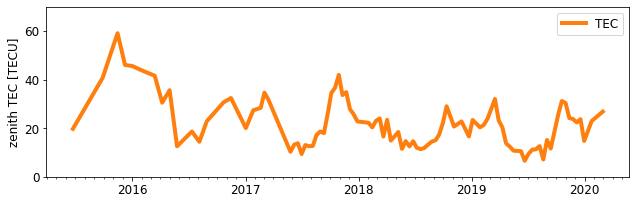

In [27]:
## plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(tDict['time'], tDict['TEC'], linewidth=4, color='C1', label='TEC')
pp.auto_adjust_xaxis_date(ax, tDict['time'], every_year=1, buffer_year=None)
ax.set_ylabel('zenith TEC [TECU]')
ax.set_ylim(0, 70)
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.legend()
fig.tight_layout()

# output
out_fig = os.path.join(os.path.dirname(out_file), '../gim_tec_v{}.png'.format(version))
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 3.2 plot - delay prediction

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/../gim_tec_v2.1_pred.png


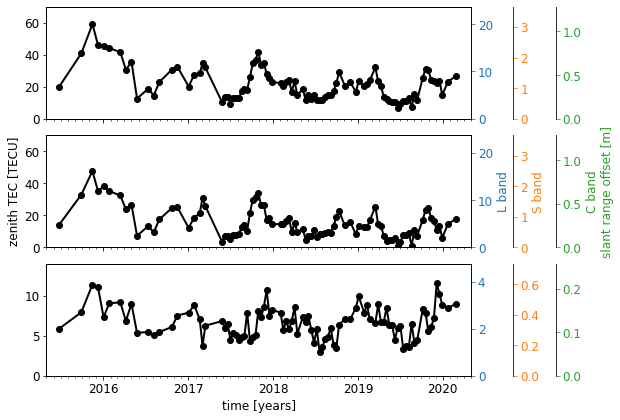

In [28]:
## data
tec_types = ['TEC', 'subTEC', 'topTEC']
bands = ['Cband', 'Sband', 'Lband']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[9, 6], sharex=True)
for i in range(len(bands)):
    tec_type = tec_types[i]

    ## plot
    ax = axs[i]
    ax.plot(tDict['time'], tDict[tec_type], '-o', label=tec_type, color='k', ms=6, lw=2)

    # axis format
    if i in [0, 1]:
        ax.set_ylim(0, 70)
    else:
        ax.set_ylim(0, 14)

    #ax.annotate(tec_type, xy=(0.23, 0.8), xycoords='axes fraction')

    # TEC ytick
    colors = ['C0', 'C1', 'C2']
    for j in range(len(bands)):
        band = bands[2-j]
        key_off = 'range_delay4{b}_{t}'.format(b=band, t=tec_type)
        pos = 1.0 + 0.1 * j
        c = colors[j]
        label = '{} band'.format(band.split('band')[0])
        if j == 2:
            label += '\nslant range offset [m]'

        ax2 = ax.twinx()
        ax2.spines['right'].set_position(('axes', pos))
        ax2.tick_params(which='both', axis='y', colors=c)

        ratio = ((np.max(tDict[key_off])  - np.min(tDict[key_off])) /
                 (np.max(tDict[tec_type]) - np.min(tDict[tec_type])))
        ax2.set_ylim(ymin=ax.get_ylim()[0] * ratio,
                     ymax=ax.get_ylim()[1] * ratio)

        if i == 1:
            ax2.set_ylabel(label, color=c)

pp.auto_adjust_xaxis_date(axs[-1], tDict['time'], every_year=1, buffer_year=None)
axs[-1].set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
axs[-1].set_xlabel('time [years]')
axs[1].set_ylabel('zenith TEC [TECU]')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# output
out_fig = os.path.join(os.path.dirname(out_file), '../gim_tec_v{}_pred.png'.format(version))
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 3.3 plot - distance between TEC TPP and SAR

min/max distance : 0.0/11.0 deg
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/gim_tec_v2.1_dist.png


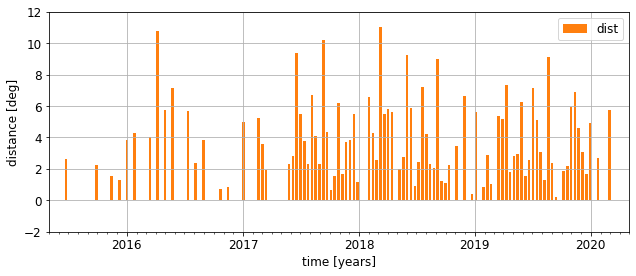

In [46]:
print('min/max distance : {:.1f}/{:.1f} deg'.format(np.min(tDict['dist_deg']), np.max(tDict['dist_deg'])))

## plot
fig, ax = plt.subplots(figsize=[9, 4])
ax.bar(tDict['time'], tDict['dist_deg'], width=8, color='C1', label='dist')
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-2, 12)
ax.set_xlabel('time [years]')
ax.set_ylabel('distance [deg]')
pp.auto_adjust_xaxis_date(ax, tDict['time'], every_year=1, buffer_year=None)
ax.grid('on')

ax.legend()
ax.grid('on')
fig.tight_layout()

# output
out_fig = os.path.join(os.path.dirname(out_file), 'gim_tec_v{}_dist.png'.format(version))
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 3.4 plot - location between TEC TPP and SAR

[==================================================] 20200228    0s /     0s 
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/gim_tec_v2.1_loc.png


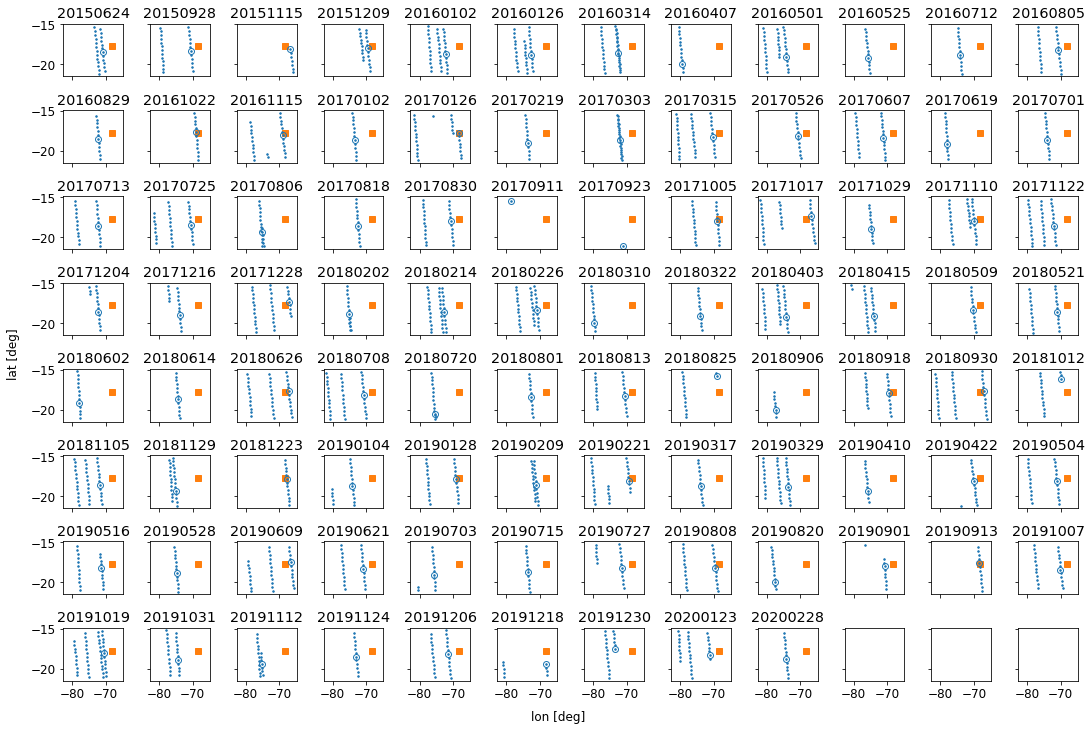

In [22]:
fig, axs = plt.subplots(figsize=[15, 10], nrows=8, ncols=12, sharex=True, sharey=True)
prog_bar = ptime.progressBar(maxValue=num_date)
for i in range(num_date):
    ax = axs.flatten()[i]
    lalo = lalo_list[i]
    ind = lalo['tec_ind']

    # plot
    ax.plot(lalo['lon'],          lalo['lat'],          's', color='C1', label='TGT')                   # SAR
    ax.plot(lalo['lon_tec'],      lalo['lat_tec'],      '.', color='C0', label='TPP', ms=3)             # TPP
    ax.plot(lalo['lon_tec'][ind], lalo['lat_tec'][ind], 'o', color='C0', label='chosen', mfc='none')    # TPP (nearest)

    ax.set_title(date_list[i])
    prog_bar.update(i+1, suffix=date_list[i])
prog_bar.close()

# axis format
fig.text(0.5, -0.01, 'lon [deg]', ha='center')
fig.text(-0.01, 0.5, 'lat [deg]', va='center', rotation='vertical')
fig.tight_layout()

# output
out_fig = os.path.join(os.path.dirname(out_file), 'gim_tec_v{}_loc.png'.format(version))
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()